In [1]:
import numpy as np
import skimage.transform
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from skimage.io import imread
from skimage.segmentation import mark_boundaries
from sklearn.metrics import roc_curve, auc
from skimage.color import label2rgb
import pandas as pd
from IPython.display import display
from glob import glob
from os.path import split, splitext, join
import tensorflow as tf
from keras.utils import multi_gpu_model

base_dir = os.path.realpath('D:\\ADE2K\\ADE20K_2016_07_26\\images')

Using TensorFlow backend.


In [2]:
path = []
jpg_path = []
for root, dir, files in os.walk(base_dir, topdown=False):
    for name in files:
        path +=(glob(os.path.join(root,name)))
        if name.endswith('.jpg'):
            jpg_path += (glob(os.path.join(root,name)))

In [3]:
all_img_df = pd.DataFrame(dict(path = jpg_path))

In [4]:
all_img_df["mask_path"] = all_img_df["path"].map(lambda x : x.replace('.jpg', '_seg.png'))
print(all_img_df["mask_path"][0])

D:\ADE2K\ADE20K_2016_07_26\images\training\a\abbey\ADE_train_00000970_seg.png


In [5]:
all_img_df["key_id"] = all_img_df["path"].map(lambda x : splitext(os.path.basename(x))[0])
all_img_df['sky_id'] = all_img_df['key_id'].map(lambda x: x.split('_')[2])
from sklearn.model_selection import train_test_split
def train_test_split_on_group(in_df, col_id, **kwargs):
    group_val = np.unique(in_df[col_id])
    train_ids, test_ids = train_test_split(group_val, **kwargs)
    return in_df[in_df[col_id].isin(train_ids)], in_df[in_df[col_id].isin(test_ids)]

train_df, valid_df = train_test_split_on_group(all_img_df, col_id='sky_id', random_state=2018,test_size=0.1)
valid_df, test_df = train_test_split_on_group(valid_df, col_id = 'sky_id', random_state = 2018, test_size = 0.5)
print(train_df.shape[0], 'training images')
print(valid_df.shape[0], 'validation images')
print(test_df.shape[0], 'test images')

20003 training images
1105 validation images
1102 test images


In [244]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

dg_args = dict(featurewise_center = False,
              samplewise_center = False,
              rotation_range = 5,
              width_shift_range = 0.01,
              height_shift_range = 0.01,
              shear_range = 0.01,
              zoom_range = [0.9, 1.1],
              horizontal_flip = True,
              vertical_flip = False,
              fill_mode = 'nearest',
              data_format = 'channels_last',
              preprocessing_function = preprocess_input)

IMG_SIZE = (256,256)
default_batch_size = 8
dg_args['preprocessing_function'] = lambda x:x/255.0
core_idg = ImageDataGenerator(**dg_args)
mask_args = dg_args.copy()
mask_args['preprocessing_function'] = lambda x:x/255.0
mask_idg = ImageDataGenerator(**mask_args)

In [245]:
def read_diff_img(c_row):
    t0_img = imread(c_row['path'])[:,:,0:3]
    cg_img = imread(c_row['mask_path'], as_grey=True)
    return (t0_img, cg_img)

In [246]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, class_mode='sparse', **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = ''
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [269]:
def make_gen(img_gen, mask_gen, in_df, batch_size = default_batch_size, seed=None, shuffle=True):
    if seed is None:
        seed = np.random.choice(range(9999))
    flow_args = dict(target_size = IMG_SIZE,
                    batch_size = batch_size,
                    seed = seed,
                    shuffle = shuffle,
                    y_col = 'sky_id')
    t0_gen = flow_from_dataframe(img_gen, in_df,
                                 path_col = 'path',
                                color_mode = 'rgb',
                                **flow_args)
    dm_gen = flow_from_dataframe(mask_gen, in_df,
                                path_col = 'mask_path',
                                color_mode = 'rgb',
                                **flow_args)
    
    for (t0_img, _), (dm_img, _) in zip(t0_gen, dm_gen):
        yield [t0_img], dm_img
        
train_gen = make_gen(core_idg, mask_idg, train_df)
valid_gen = make_gen(core_idg, mask_idg, valid_df, seed=0, shuffle= False)
test_gen = make_gen(core_idg, mask_idg, test_df, seed=0, shuffle=False, batch_size =2*default_batch_size)
[t0_img], dm_img_1 = next(train_gen)
dm_img = dm_img_1[:,:,:,0].reshape(8,256,256,1)

print(t0_img.shape, t0_img.max())
print(dm_img.shape, dm_img.max(), dm_img.mean())

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 20003 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 20003 images
(8, 256, 256, 3) 1.0
(8, 256, 256, 1) 0.43137255 0.2016502


(8, 256, 256, 1)


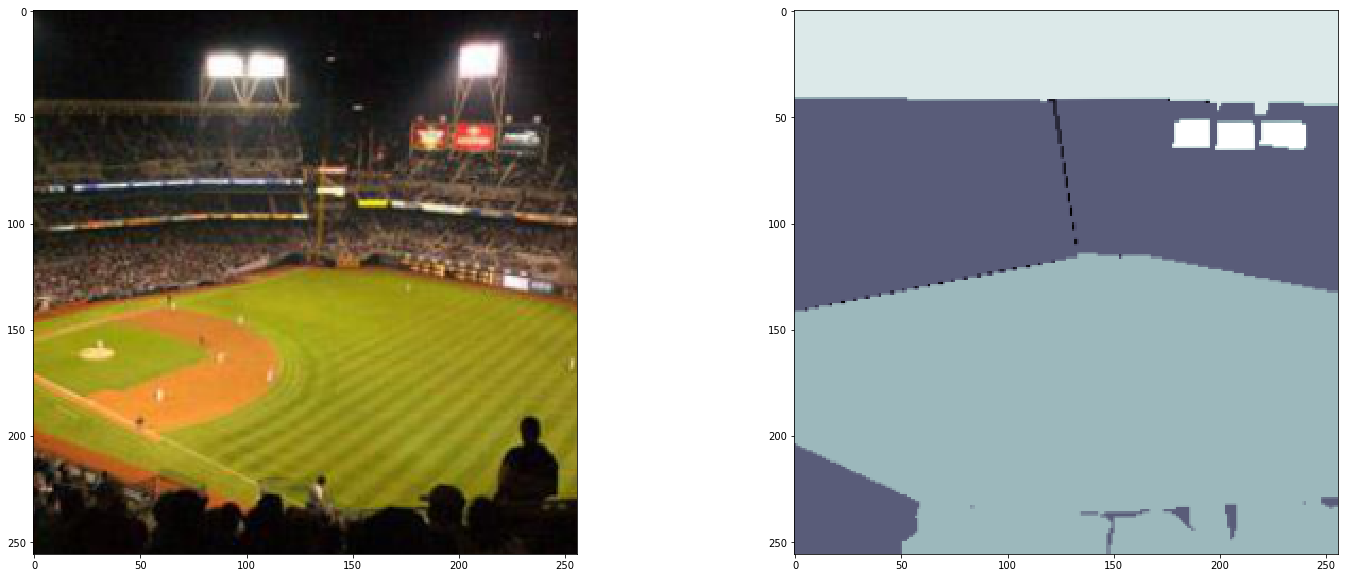

In [271]:
#import skimage
#from skimage.util.montage import montage2d
#n_rgb = lambda x: np.stack([(x[:, :, i]-x[:, :, i].min())/(x[:, :, i].max()-x[:, :, i].min()) for i in range(x.shape[2])], 2)[:, :, ::-1]
#nn_rgb = lambda x: n_rgb(np.stack([montage2d(x[:, :, :, i]) for i in range(x.shape[3])], -1))
print(dm_img.shape)
fig, (ax1, ax3) = plt.subplots(1, 2, figsize = (25, 10))
ax1.imshow((t0_img[5, :, :, :].reshape(256,256,3)), cmap = 'bone')
#ax1.set_title('$T_0$ Image')
ax3.imshow((dm_img[5, :, :, :].reshape(256,256)), cmap = 'bone')
#ax3.set_title('$\Delta$T Mask')


In [272]:
from keras.applications.vgg16 import VGG16 as PTModel
base_pretrained_model = PTModel(input_shape = t0_img.shape[1:], include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False

In [273]:
from collections import defaultdict, OrderedDict
from keras.models import Model
layer_size_dict = defaultdict(list)
inputs = []
for lay_idx, c_layer in enumerate(base_pretrained_model.layers):
    if not c_layer.__class__.__name__ == 'InputLayer':
        layer_size_dict[c_layer.get_output_shape_at(0)[1:3]] += [c_layer]
    else:
        inputs +=[c_layer]
layer_size_dict = OrderedDict(layer_size_dict.items())
for k,v in layer_size_dict.items():
    print(k, [w.__class__.__name__ for w in v])

(256, 256) ['Conv2D', 'Conv2D']
(128, 128) ['MaxPooling2D', 'Conv2D', 'Conv2D']
(64, 64) ['MaxPooling2D', 'Conv2D', 'Conv2D', 'Conv2D']
(32, 32) ['MaxPooling2D', 'Conv2D', 'Conv2D', 'Conv2D']
(16, 16) ['MaxPooling2D', 'Conv2D', 'Conv2D', 'Conv2D']
(8, 8) ['MaxPooling2D']


In [274]:
#tahe the last layer in each shape and make it into an output
pretrained_encoder = Model(inputs = base_pretrained_model.get_input_at(0), outputs = [v[-1].get_output_at(0) for k,v in layer_size_dict.items()])
pretrained_encoder.trainable = False
n_outputs = pretrained_encoder.predict([t0_img])
for c_out, (k,v) in zip(n_outputs, layer_size_dict.items()):
    print(c_out.shape, 'expected', k)

(8, 256, 256, 64) expected (256, 256)
(8, 128, 128, 128) expected (128, 128)
(8, 64, 64, 256) expected (64, 64)
(8, 32, 32, 512) expected (32, 32)
(8, 16, 16, 512) expected (16, 16)
(8, 8, 8, 512) expected (8, 8)


In [284]:
from keras.layers import Input, Conv2D, concatenate, UpSampling2D, BatchNormalization, Activation, Cropping2D, ZeroPadding2D
x_wid, y_wid = t0_img.shape[1:3]
in_t0 = Input(t0_img.shape[1:], name = 'T0_Image')
wrap_encoder = lambda i_layer: {k:v for k,v in zip(layer_size_dict.keys(), pretrained_encoder(i_layer))}
t0_outputs = wrap_encoder(in_t0)
lay_dims = sorted(t0_outputs.keys(), key=lambda x:x[0])
print (lay_dims)
skip_layers = 2
last_layer = None

for k in lay_dims[skip_layers:]:
    cur_layer = t0_outputs[k]
    channel_count = cur_layer._keras_shape[-1]
    cur_layer = Conv2D(channel_count//2, kernel_size=(3,3), padding='same', activation='linear')(cur_layer)
    cur_layer = BatchNormalization()(cur_layer) # gotta keep an eye on that internal covariant shift
    cur_layer = Activation('relu')(cur_layer)
    
    if last_layer is None:
        x = cur_layer
    else:
        last_channel_count = last_layer._keras_shape[-1]
        x = Conv2D(last_channel_count//2, kernel_size=(3,3), padding = 'same')(last_layer)
        x = UpSampling2D((2,2))(x)
        x = concatenate([cur_layer, x])
    last_layer = x
final_output = Conv2D(dm_img.shape[-1], kernel_size=(1,1), padding='same', activation='softmax')(last_layer)
#crop_size = 20
#final_output = Cropping2D((crop_size, crop_size))(final_output)
#final_output = ZeroPadding2D((crop_size, crop_size))(final_output)

unet_model = Model(inputs = [in_t0],
                   outputs = [final_output])

unet_model.summary()

[(8, 8), (16, 16), (32, 32), (64, 64), (128, 128), (256, 256)]
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
T0_Image (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
model_32 (Model)                [(None, 256, 256, 64 14714688    T0_Image[0][0]                   
__________________________________________________________________________________________________
conv2d_159 (Conv2D)             (None, 32, 32, 256)  1179904     model_32[6][3]                   
__________________________________________________________________________________________________
batch_normalization_80 (BatchNo (None, 32, 32, 256)  1024        conv2d_159[0][0]                 
______________________________________________

In [276]:
"""
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_p_bce(in_gt, in_pred):
    return 1.0*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)

unet_model.compile(optimizer=Adam(1e-3, decay = 1e-6), 
                   loss=dice_p_bce, 
                   metrics=[dice_coef, 'binary_accuracy', true_positive_rate])
loss_history = []


"""
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)
def dice_p_bce(in_gt, in_pred):
    return  1 - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)

unet_model.compile(optimizer=Adam(1e-4, decay = 1e-6), 
                   loss=dice_p_bce, 
                   metrics=[dice_coef, 'binary_accuracy'])
loss_history = []

In [277]:
"""
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('vgg_unet')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

"""
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('vgg_unet')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.00001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=10) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]


C:\Anaconda3\envs\dl\lib\site-packages\keras\callbacks.py:999: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [278]:
import gc
gc.collect()
loss_history += [unet_model.fit_generator(make_gen(core_idg, mask_idg, train_df), 
                                         steps_per_epoch=min(1000, train_df.shape[0]//t0_img.shape[0]), 
                                         epochs = 10, 
                                           validation_data = valid_gen,
                                        validation_steps = valid_df.shape[0]//t0_img.shape[0],
                                         callbacks = callbacks_list,
                                        workers = 2)]


## Ignore next message from keras, values are replaced anyways
Epoch 1/10
Found 0 images belonging to 0 classes.
Reinserting dataframe: 20003 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 20003 images
  21/1000 [..............................] - ETA: 6:09 - loss: -0.1939 - dice_coef: 1.1939 - binary_accuracy: 0.0098

KeyboardInterrupt: 

KeyError: 'true_positive_rate'

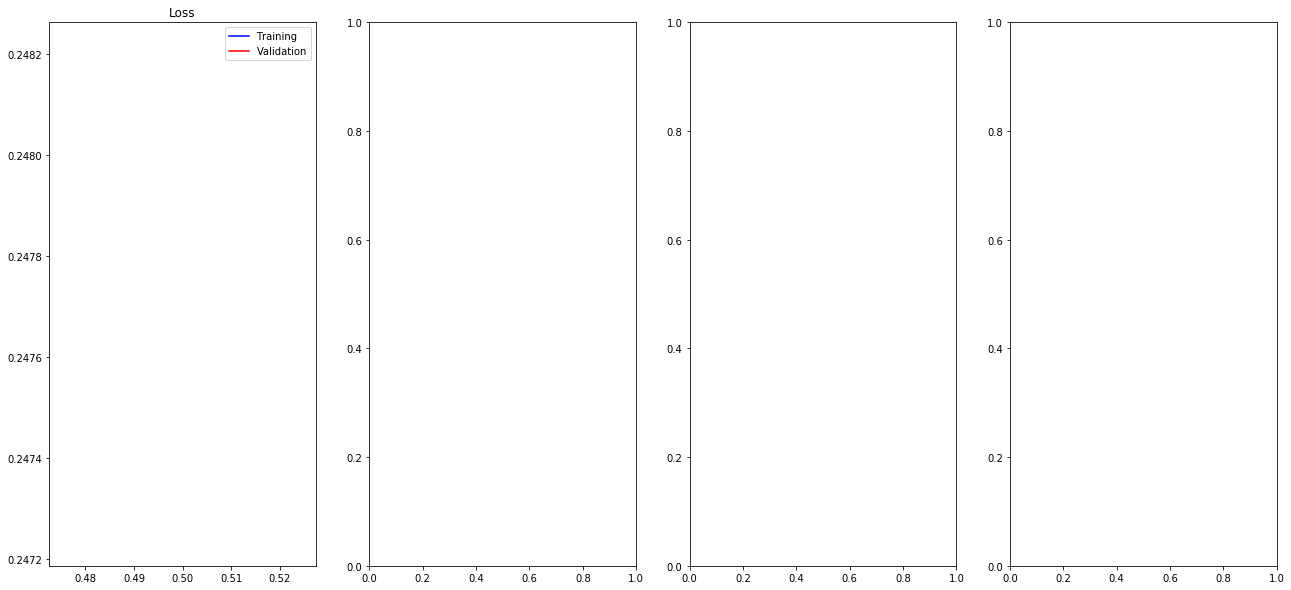

In [234]:
def show_loss(loss_history):
    epich = np.cumsum(np.concatenate(
        [np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22, 10))
    _ = ax1.plot(epich,
                 np.concatenate([mh.history['loss'] for mh in loss_history]),
                 'b-',
                 epich, np.concatenate(
            [mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')

    _ = ax2.plot(epich, np.concatenate(
        [mh.history['true_positive_rate'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_true_positive_rate'] for mh in loss_history]),
                     'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('True Positive Rate\n(Positive Accuracy)')
    
    _ = ax3.plot(epich, np.concatenate(
        [mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_binary_accuracy'] for mh in loss_history]),
                     'r-')
    ax3.legend(['Training', 'Validation'])
    ax3.set_title('Binary Accuracy (%)')
    
    _ = ax4.plot(epich, np.concatenate(
        [mh.history['dice_coef'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_dice_coef'] for mh in loss_history]),
                     'r-')
    ax4.legend(['Training', 'Validation'])
    ax4.set_title('DICE')

show_loss(loss_history)

In [266]:
unet_model.load_weights('vgg_unet_weights.best.hdf5')

In [267]:
unet_model.save('full_seg_model.h5')

(8, 256, 256, 3)
[[0.         0.03566753 0.03921569 ... 0.03921569 0.03921569 0.03921569]
 [0.00233459 0.03842155 0.03921569 ... 0.03921569 0.03921569 0.03921569]
 [0.00508861 0.03921569 0.03921569 ... 0.03921569 0.03921569 0.03921569]
 ...
 [0.43137255 0.20499358 0.11764706 ... 0.11764706 0.11764706 0.11764706]
 [0.43137255 0.18296143 0.11764706 ... 0.11764706 0.11764706 0.11764706]
 [0.43137255 0.1609293  0.11764706 ... 0.11764706 0.11764706 0.11764706]]


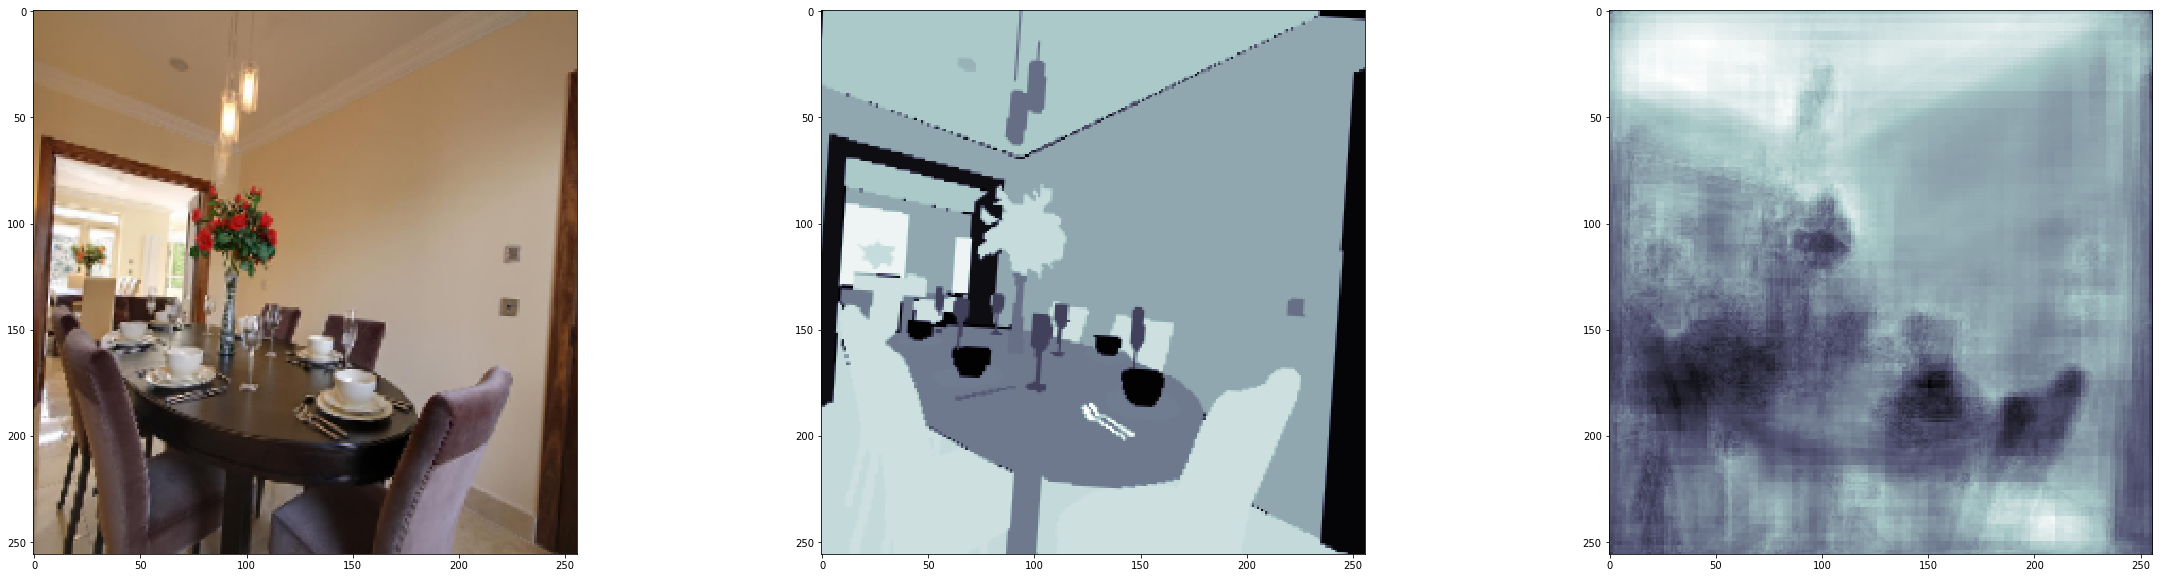

In [268]:
[t0_img], dm_img = next(train_gen)
dm_pred = unet_model.predict([t0_img])
print(dm_pred.shape)
print(dm_img[5,0:100,0:100,0])
fig, (ax1, ax3, ax4) = plt.subplots(1, 3, figsize = (40, 10))
ax1.imshow((t0_img[5, :, :, :].reshape(256,256,3)), cmap = 'bone')
ax3.imshow((dm_img[5, :, :, 1].reshape(256,256)), cmap = 'bone')
ax4.imshow((dm_pred[5, :, :, 1].reshape(256,256)), cmap = 'bone')


In [222]:
from PIL import Image
j = Image.fromarray((dm_img[5,:,:,0].reshape(512,512)))
j.save("mask.tiff")
j = Image.fromarray((dm_pred[5,:,:,0].reshape(512,512)))
j.save("pred.tiff")

TypeError: 'module' object is not callable

channels_last
